In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random as rd
import numpy as np
import torch
from torch.utils.data import DataLoader
import gymnasium as gym
from transformers import AutoImageProcessor

In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from transformers import AutoImageProcessor
from stable_baselines3 import PPO
from stable_baselines3.common import env_checker


from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.img_env.img_exploration_env import ImageExplorationEnv, ImageExplorationEnvConfig, RewardFunction
from uav_active_sensing.mae.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.agents.rl_agent_feature_extractor import CustomResNetFeatureExtractor
from uav_active_sensing.config import DEVICE
from uav_active_sensing.plots import visualize_tensor, visualize_act_mae_reconstruction

In [15]:
SEED = 1230

In [6]:
generator = torch.Generator().manual_seed(SEED)

In [7]:
class SingleImageDataset(Dataset):
    def __init__(self, original_dataset: Dataset, index: int):
        self.image, self.label = original_dataset[index]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.image, self.label

In [11]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)  # TODO: Download this in advance
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
random_index = rd.randint(0, len(tiny_imagenet_train_dataset) - 1)
single_image_dataset = SingleImageDataset(tiny_imagenet_train_dataset, random_index)
tiny_imagenet_train_loader = DataLoader(single_image_dataset, batch_size=2, collate_fn=tiny_imagenet_collate_fn)

# Pretrained model and reward function
act_mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")  # TODO: Download this in advance
reward_function = RewardFunction(act_mae_model,
                                 num_samples=1,
                                 reward_increase=False,
                                 patch_size=16,
                                 masking_ratio=0.8,
                                 generator=generator,
                                 mask_sample=False,
                                 )

# Create a dummy environment to initialize the model
img = next(iter(tiny_imagenet_train_loader))[0]  # Take one image as a dummy input for env initialization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


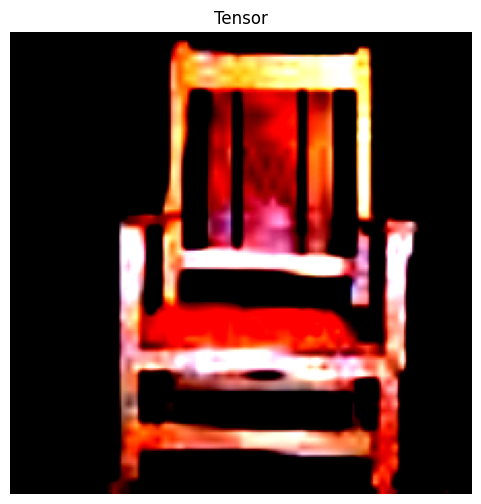

In [13]:
visualize_tensor(img)

### Test random movement

In [17]:
env_config = ImageExplorationEnvConfig(reward_function=reward_function, seed=45, sensor_size=16 * 2)
env = ImageExplorationEnv(single_image_dataset, seed=SEED, env_config=env_config)

In [18]:
env_checker.check_env(env)

/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:55: UserWarning: It seems that your observation sampled_img is an image but its `dtype` is (float32) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:63: UserWarning: It seems that your observation space sampled_img is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(


In [19]:
env.reset()
for j in range(128):
    sample_action = env.action_space.sample()
    # print(sample_action)
    # print(env._denormalize_action(torch.from_numpy(sample_action)))
    env.step(sample_action)

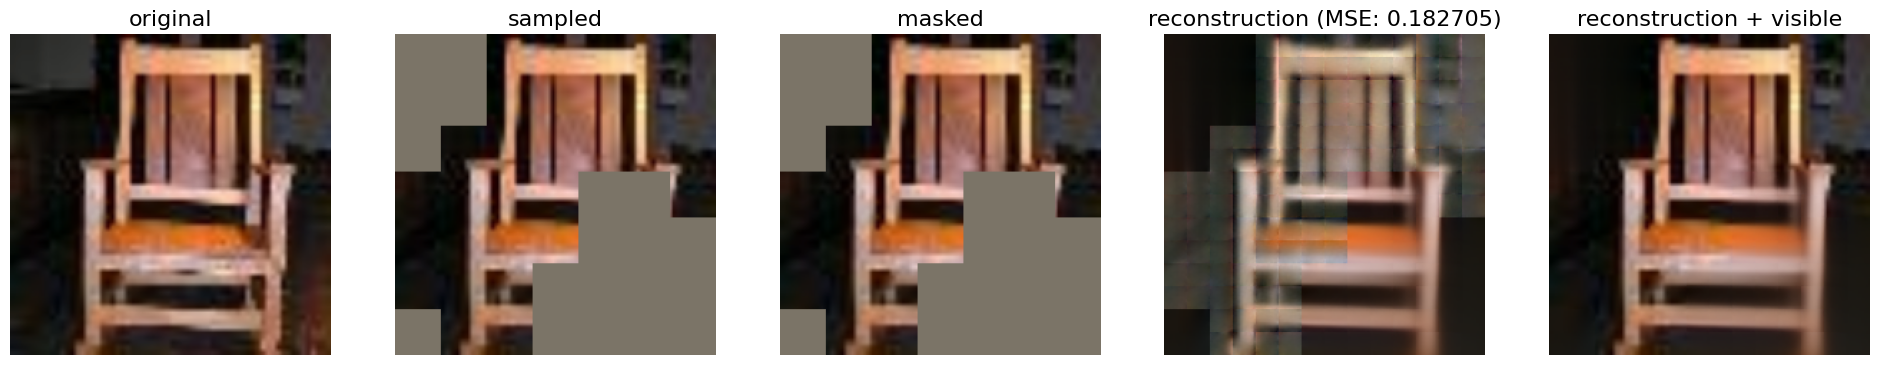

In [23]:
masked_sampled_img = env.reward_function.sampled_img_random_masking(env.sampled_img)
visualize_act_mae_reconstruction(env.img.unsqueeze(0), env.sampled_img.unsqueeze(0), env.sampled_img.unsqueeze(0), act_mae_model)

### Multi agent exploration implementation

* This should vectorize all elements of the MDP
* How does this talk with SB3?

In [33]:
reward_function_ma = RewardFunction(act_mae_model,
                                 num_agents=3,
                                 reward_increase=False,
                                 patch_size=16,
                                 masking_ratio=0.8,
                                 generator=generator,
                                 mask_sample=False,
                                 )

In [34]:
reward_function_ma(env.img, env.sampled_img)

tensor([0.8455, 0.8455, 0.8455])